In [513]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

This is my second attempt with pipeline to predict the survival.

In [514]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

In [515]:
titanic = pd.read_csv('train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [516]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [517]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [518]:
pd.DataFrame({'Integer': ['Survived','Pclass','SibSp, Parch','-'], 
              'Float': ['-','-','-','Age, Fare'], 
              'Object': ['Sex, Name, Ticket, Cabin, Embarked','-','-','-']}, 
              index = ['Nominal','Ordinal','Discrete','Continuous'])

,Integer,Float,Object
Nominal,Survived,-,"Sex, Name, Ticket, Cabin, Embarked"
Ordinal,Pclass,-,-
Discrete,"SibSp, Parch",-,-
Continuous,-,"Age, Fare",-


In [519]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [520]:
titanic.isnull().sum()*100/len(titanic)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [521]:
titanic_catg = titanic[['Sex', 'Cabin', 'Ticket', 'Pclass', 'Embarked']]
titanic_num = titanic[['Fare', 'Age', 'SibSp', 'Parch', 'Survived']]

In [522]:
titanic_num.corr()

,Fare,Age,SibSp,Parch,Survived
Fare,1.000000,0.096067,0.159651,0.216225,0.257307
Age,0.096067,1.000000,-0.308247,-0.189119,-0.077221
SibSp,0.159651,-0.308247,1.000000,0.414838,-0.035322
Parch,0.216225,-0.189119,0.414838,1.000000,0.081629
Survived,0.257307,-0.077221,-0.035322,0.081629,1.000000


<Axes: xlabel='Survived', ylabel='count'>

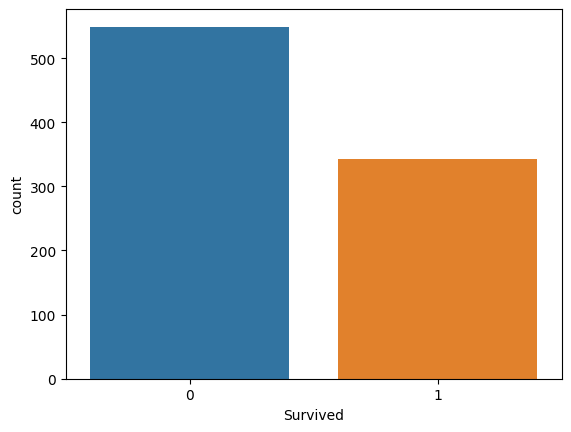

In [523]:
sns.countplot(titanic, x='Survived')

<Axes: xlabel='SibSp', ylabel='count'>

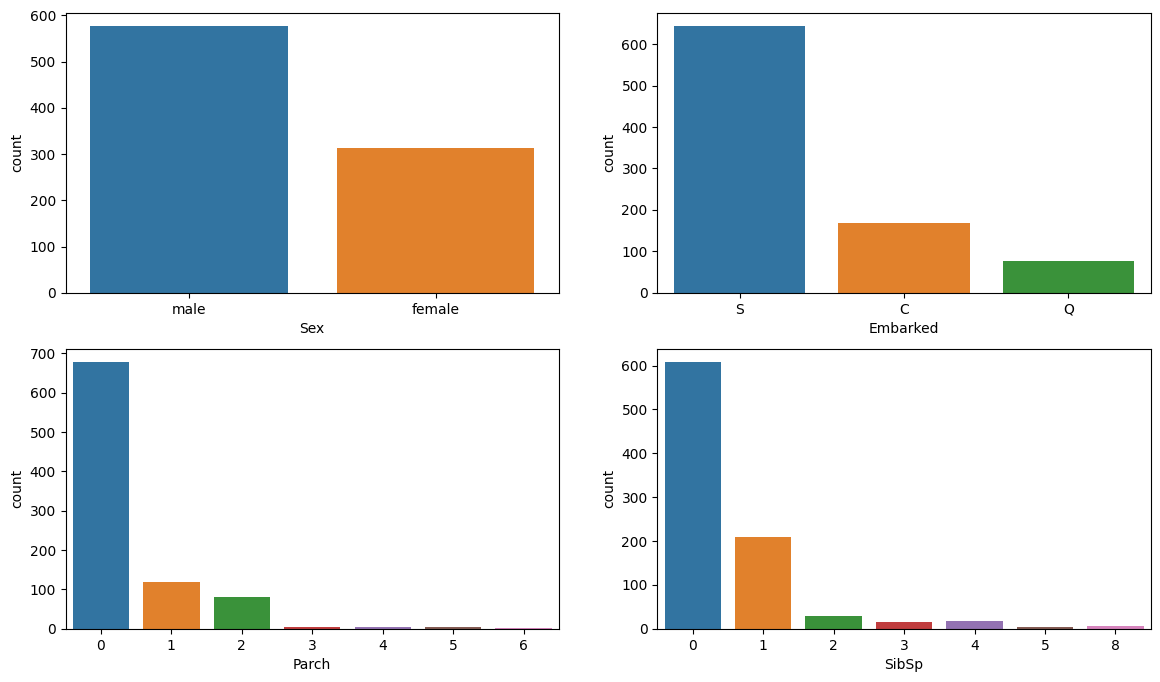

In [524]:
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.countplot(titanic, x='Sex')
plt.subplot(222)
sns.countplot(titanic, x='Embarked')
plt.subplot(223)
sns.countplot(titanic, x='Parch')
plt.subplot(224)
sns.countplot(titanic, x='SibSp')

<Axes: xlabel='SibSp', ylabel='count'>

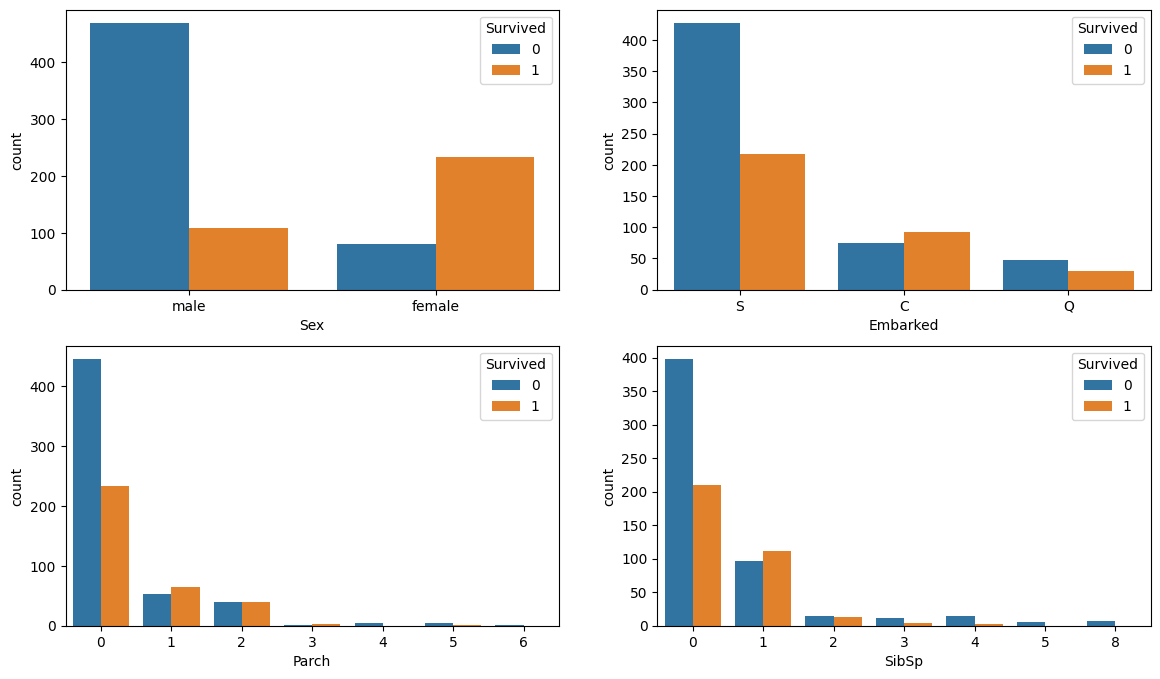

In [525]:
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.countplot(titanic, x='Sex', hue='Survived')
plt.subplot(222)
sns.countplot(titanic, x='Embarked', hue='Survived')
plt.subplot(223)
sns.countplot(titanic, x='Parch', hue='Survived')
plt.subplot(224)
sns.countplot(titanic, x='SibSp', hue='Survived')

In [526]:
# Define the count_n_plot function
def count_n_plot(df, col_name, countsplit = None, bar = False, barsplit = None):
    
    """
    Creates countplots and barplots of the specified feature 
    (with options to split the columns) and generates the 
    corresponding table of counts and percentages.
    
    Parameters
    ----------
    df : DataFrame
        Dataset for plotting.
    col_name : string
        Name of column/feature in "data".
    countsplit : string
        Use countsplit to specify the "hue" argument of the countplot.
    bar : Boolean
        If True, a barplot of the column col_name is created, showing
        the fraction of survivors on the y-axis.
    barsplit: string
        Use barsplit to specify the "hue" argument of the barplot.
    """

    if (countsplit != None) & bar & (barsplit != None):
        col_count1 = df[[col_name]].groupby(by = col_name).size()
        col_perc1 = col_count1.apply(lambda x: x / sum(col_count1) * 100).round(1)
        tcount1 = pd.DataFrame({'Count': col_count1, 'Percentage': col_perc1})
        
        col_count2 = df[[col_name,countsplit]].groupby(by = [col_name,countsplit]).size()
        col_perc2 = col_count2.apply(lambda x: x / sum(col_count2) * 100).round(1)
        tcount2 = pd.DataFrame({'Count': col_count2, 'Percentage': col_perc2})
        display(tcount1, tcount2) 
        
        figc, axc = plt.subplots(1, 2, figsize = (10,4))
        sns.countplot(data = df, x = col_name, hue = None, ax = axc[0])
        sns.countplot(data = df, x = col_name, hue = countsplit, ax = axc[1])
        
        figb, axb = plt.subplots(1, 2, figsize = (10,4))
        sns.barplot(data = df, x = col_name, y = 'Survived', hue = None, ax = axb[0])
        sns.barplot(data = df, x = col_name, y = 'Survived', hue = barsplit, ax = axb[1])

    elif (countsplit != None) & bar:
        col_count1 = df[[col_name]].groupby(by = col_name).size()
        col_perc1 = col_count1.apply(lambda x: x / sum(col_count1) * 100).round(1)
        tcount1 = pd.DataFrame({'Count': col_count1, 'Percentage': col_perc1})
        
        col_count2 = df[[col_name,countsplit]].groupby(by = [col_name,countsplit]).size()
        col_perc2 = col_count2.apply(lambda x: x / sum(col_count2) * 100).round(1)
        tcount2 = pd.DataFrame({'Count': col_count2, 'Percentage': col_perc2})
        display(tcount1, tcount2)
        
        fig, axes = plt.subplots(1, 3, figsize = (15,4))
        sns.countplot(data = df, x = col_name, hue = None, ax = axes[0])
        sns.countplot(data = df, x = col_name, hue = countsplit, ax = axes[1])
        sns.barplot(data = df, x = col_name, y = 'Survived', hue = None, ax = axes[2])
        
    elif countsplit != None:
        col_count1 = df[[col_name]].groupby(by = col_name).size()
        col_perc1 = col_count1.apply(lambda x: x / sum(col_count1) * 100).round(1)
        tcount1 = pd.DataFrame({'Count': col_count1, 'Percentage': col_perc1})

        col_count2 = df[[col_name,countsplit]].groupby(by = [col_name,countsplit]).size()
        col_perc2 = col_count2.apply(lambda x: x / sum(col_count2) * 100).round(1)
        tcount2 = pd.DataFrame({'Count': col_count2, 'Percentage': col_perc2})
        display(tcount1, tcount2)
        
        fig, axes = plt.subplots(1, 2, figsize = (10,4))
        sns.countplot(data = df, x = col_name, hue = None, ax = axes[0])
        sns.countplot(data = df, x = col_name, hue = countsplit, ax = axes[1])
        
    else:
        col_count = df[[col_name]].groupby(by = col_name).size()
        col_perc = col_count.apply(lambda x: x / sum(col_count) * 100).round(1)
        tcount1 = pd.DataFrame({'Count': col_count, 'Percentage': col_perc})
        display(tcount1)        
        
        sns.countplot(data = df, x = col_name)

,Count,Percentage
Survived,,
0,549,61.6
1,342,38.4


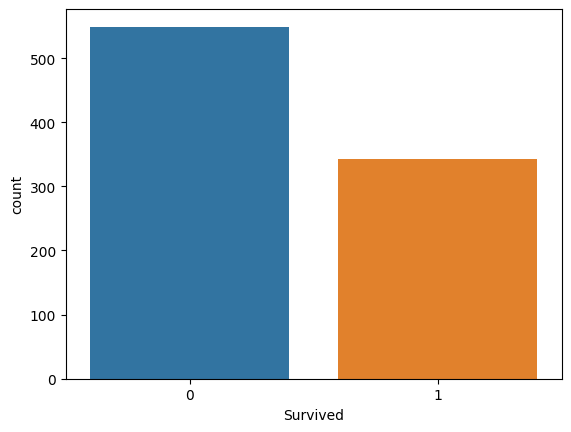

In [527]:
count_n_plot(df=titanic, col_name='Survived')

,Count,Percentage
Pclass,,
1,216,24.2
2,184,20.7
3,491,55.1


Count  Percentage
Pclass Survived                   
1      0            80         9.0
       1           136        15.3
2      0            97        10.9
       1            87         9.8
3      0           372        41.8
       1           119        13.4

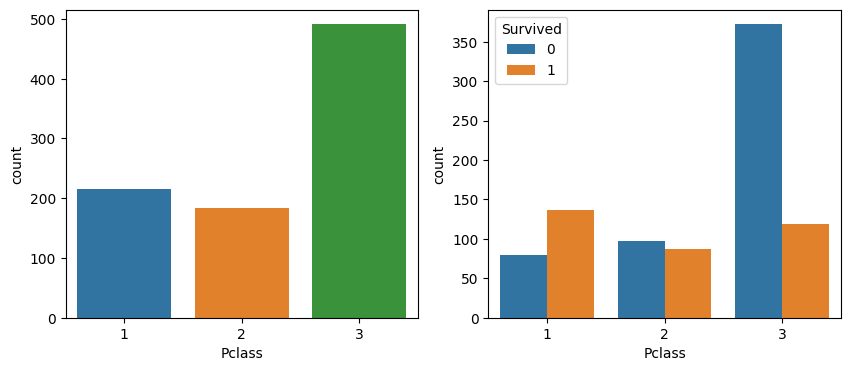

In [528]:
count_n_plot(df=titanic, col_name='Pclass', countsplit='Survived')

In [529]:
knn = KNNImputer()
titanic['Age'] = knn.fit_transform(titanic[['Age']])

In [530]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [531]:
#since, embarked has only two missing values we will use mode to fill this up.

mode_embarked= titanic['Embarked'].mode()[0]
mode_embarked

'S'

In [532]:
titanic['Embarked'].replace(np.nan, mode_embarked, inplace=True)
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [533]:
#since, we can see that our cabin has more than 70% missing values theredore we will drop this column.
#also,we have name and passnegerid with us which currently of no use in model training therfore we will drop it too
titanic.drop(columns=['Cabin', 'Name', 'PassengerId', 'Ticket', 'Embarked'],  inplace= True)

In [534]:
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [535]:
# here, we have sex column which also signifies and imp. role in our prediction model therefore we will convert it
# into binary form
titanic = pd.get_dummies(titanic, columns=['Sex'], dtype=int)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


In [536]:
#drop one either sex_male or sex_female

titanic.drop(columns='Sex_female', inplace=True)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male
0,0,3,22.0,1,0,7.2500,1
1,1,1,38.0,1,0,71.2833,0
2,1,3,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,0,3,35.0,0,0,8.0500,1


In [537]:
#same goes for the pclass
titanic = pd.get_dummies(titanic, columns=['Pclass'], drop_first=True, dtype=int)
titanic.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,0
4,0,35.0,0,0,8.0500,1,0,1


We need to analyse the test data set too.

In [538]:
titanic_test = pd.read_csv('test.csv')
titanic_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [539]:
titanic_test['Age'] = knn.fit_transform(titanic_test[['Age']])

In [540]:
titanic_test.isnull().sum()*100/len(titanic_test)

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

In [541]:
mode_fare = titanic_test['Fare'].mode()[0]
mode_fare

7.75

In [542]:
titanic_test['Fare'].replace(np.nan, mode_fare , inplace=True)

In [543]:
titanic_test_passId = titanic_test.iloc[:,0]
titanic_test = titanic_test.iloc[:,1:]

In [544]:
titanic_test.drop(columns=['Name', 'Ticket', 'Cabin','Embarked'], inplace=True)
titanic_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875


In [545]:
titanic_test = pd.get_dummies(titanic_test, columns=['Sex', 'Pclass'], drop_first=True, dtype=int)
titanic_test.head()

,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,1,0,1
1,47.0,1,0,7.0000,0,0,1
2,62.0,0,0,9.6875,1,1,0
3,27.0,0,0,8.6625,1,0,1
4,22.0,1,1,12.2875,0,0,1


In [546]:
titanic_test.isnull().sum()

Age         0
SibSp       0
Parch       0
Fare        0
Sex_male    0
Pclass_2    0
Pclass_3    0
dtype: int64

In [547]:
x_train = titanic.iloc[:,1:]
y_train = titanic['Survived']
x_test = titanic_test

In [548]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

c:\Users\itsab\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [549]:
titanic.head()

,Survived,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,1,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,0
4,0,35.0,0,0,8.0500,1,0,1


In [550]:
titanic_test.head()

,Age,SibSp,Parch,Fare,Sex_male,Pclass_2,Pclass_3
0,34.5,0,0,7.8292,1,0,1
1,47.0,1,0,7.0000,0,0,1
2,62.0,0,0,9.6875,1,1,0
3,27.0,0,0,8.6625,1,0,1
4,22.0,1,1,12.2875,0,0,1


In [551]:
pred = lr.predict(x_test)
pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [552]:
pred = pd.Series(pred, name='Survived')
pred.head()

0    0
1    0
2    0
3    0
4    1
Name: Survived, dtype: int64

In [553]:
sub = pd.concat([titanic_test_passId, pred], axis=1)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [554]:
result = sub.to_csv('Submission1.csv', index=False)